# NLP Project

In this project, it will be build a spam detector using URLs instead of emails.

## Importing Libraries

In [1]:
### Load libraries and modules ###
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
import regex as re
import nltk
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, svm
# Metrics --------------------------------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading the dataset

In [2]:
# Loading the dataset
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
# Create a copy of the original dataset
df = df_raw.copy()

## Data Exploration



In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [4]:
df_raw.sample(10)

,url,is_spam
2709,https://bigspaceship.us9.list-manage.com/profile,True
511,https://www.axios.com/texas-coronavirus-cases-...,False
243,https://www.politico.com/news/2020/06/21/takea...,False
1698,https://futurism.com/the-byte/michigan-illegal...,False
1914,https://www.wired.co.uk/article/fbi-forensic-p...,False
1843,https://www.nytimes.com/2020/06/18/us/american...,False
2700,https://www.fastcompany.com/90522982/walmart-y...,False
2448,https://dittowords.com/,False
2604,https://www.morningbrew.com/daily/stories/,True
696,https://deadline.com/2020/06/terry-crews-says-...,False


In [5]:
df_raw['is_spam'].value_counts()

False    2303
True      696
Name: is_spam, dtype: int64

### Null or duplicated values check

In [6]:
print("Null values:\n",df_raw.isnull().sum().sort_values(ascending=False))
print('\n')
print("There is any duplicated values? ",df_raw.duplicated().any())

Null values:
 url        0
is_spam    0
dtype: int64


There is any duplicated values?  True


In [7]:
# How many duplicated entries?
len(df_raw[df_raw.duplicated() == True])

630

## Data transformation and processing

### Transformation

#### Encoding of the target variable

In [8]:
# Encoding of the target variable
df['is_spam'] = df['is_spam'].map({True : 1, False: 0})

In [9]:
df.head(5)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


#### Deletion of duplicated data

In [10]:
# We remove the duplicated data
df = df[df.duplicated() == False]

In [11]:
len(df[df.duplicated() == True])

0

### Processing the data

In [12]:
def url_cleaner(url):
  # Remove the start of the url, the protocol and the www
  url_clean = re.sub(r'(https://www|https://|http://www|http://)', '', url)
  # Remove the commas from the url
  url_clean = re.sub(',', ' ', url_clean)
  # url in lower case
  url_clean = url_clean.lower()
  # remove special characters
  url_clean = re.sub('(\\W)+',' ',url_clean)
  # remove duplicated words
  url_clean = re.sub(r'\b(\w+)( \1\b)+', r'\1',url_clean)
  # remove multiple space
  url_clean = re.sub(' +', ' ',url_clean)
  # remove punctuation
  url_clean = re.sub('[^a-zA-Z]', ' ', url_clean)
  # remove tags
  url_clean=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",url_clean)
  return url_clean

In [13]:
df['url_clean'] = df['url'].apply(url_cleaner)

In [14]:
df.head(5)

,url,is_spam,url_clean
0,https://briefingday.us8.list-manage.com/unsubs...,1,briefingday us list manage com unsubscribe
1,https://www.hvper.com/,1,hvper com
2,https://briefingday.com/m/v4n3i4f3,1,briefingday com m v n i f
3,https://briefingday.com/n/20200618/m#commentform,0,briefingday com n m commentform
4,https://briefingday.com/fan,1,briefingday com fan


#### Removal of stop words

In [15]:
# Building a stop words list
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:5])

['i', 'me', 'my', 'myself', 'we']


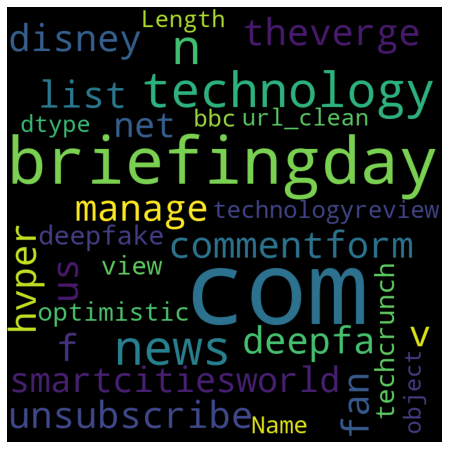

In [16]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', stopwords = stopwords, max_words = 1000
                      , min_font_size = 20).generate(str(df['url_clean']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
def remove_stopwords(text):
    text=' '.join([word for word in text.split() if word not in stopwords])
    return text

In [18]:
df['url_clean'] = df['url_clean'].apply(remove_stopwords)

In [19]:
df.head(5)

,url,is_spam,url_clean
0,https://briefingday.us8.list-manage.com/unsubs...,1,briefingday us list manage com unsubscribe
1,https://www.hvper.com/,1,hvper com
2,https://briefingday.com/m/v4n3i4f3,1,briefingday com v n f
3,https://briefingday.com/n/20200618/m#commentform,0,briefingday com n commentform
4,https://briefingday.com/fan,1,briefingday com fan


## Construction of the model and results

Using CountVectorizer() to transform the body of text into a sparse matrix of numbers that the computer can pass to machine learning algorithm.

In [20]:
# Create sparse matrix
message_vectorizer = CountVectorizer().fit_transform(df['url_clean'])

In [21]:
# Spliting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(message_vectorizer, df['is_spam'], test_size = 0.45, random_state = 42, shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1302, 5908) (1067, 5908) (1302,) (1067,)


The classifier algorithm is using Support Vector Machine.

In [22]:
classifier = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
classifier.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [24]:
y_pred = classifier.predict(X_test)

#### Model Evaluation

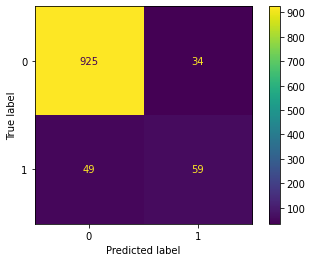



              precision    recall  f1-score   support

           0       0.95      0.96      0.96       959
           1       0.63      0.55      0.59       108

    accuracy                           0.92      1067
   macro avg       0.79      0.76      0.77      1067
weighted avg       0.92      0.92      0.92      1067



Support Vector Machine Mean absolute error: 0.07778819119025304


Support Vector Machine Train Accuracy =  0.9900153609831029
Support Vector Machine Test Accuracy =  0.922211808809747


Support Vector Machine Precision score: 0.6344086021505376


Support Vector Machine Recall score: 0.5462962962962963


In [25]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=classifier.classes_)
disp.plot()
plt.show()
print("\n")
print(classification_report(y_test,y_pred))
print("\n")
print("Support Vector Machine Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("\n")
print('Support Vector Machine Train Accuracy = ',accuracy_score(y_train,classifier.predict(X_train)))
print('Support Vector Machine Test Accuracy = ',accuracy_score(y_test,classifier.predict(X_test)))
print("\n")
print("Support Vector Machine Precision score:",precision_score(y_test, y_pred))
print("\n")
print("Support Vector Machine Recall score:",recall_score(y_test, y_pred))